In [18]:
import tensorflow as tf
from utils import actomyosin_data, plot64
from model.autoencoder_3d_xy48_t8 import AE
from train_utils.autoencoder import AETrain, VAETrain, CVAETrain
import time
import argparse
from datetime import datetime
from packaging import version
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import tifffile
import os
import warnings
from itertools import cycle, islice

from skimage.transform import resize
from skimage.io import imsave, imread

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

In [19]:
# args
ae_type = 'AE'
net_type = 'simple'
latent_dim = 12
num_epochs = 1000
learn_rate = 0.001
train_buf = 12000
batch_size = 512

In [34]:
num_epochs = 1000

In [20]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [21]:
import tensorboard
tensorboard.__version__

'2.12.1'

In [22]:
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

2024-09-23 09:11:23.599558: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-09-23 09:11:23.599594: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-09-23 09:11:23.599869: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-09-23 09:11:23.600209: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed


In [23]:
data_dir = '/mnt/d/lding/actomyosin/data/partitioned_data/VidS1_ps48_flows2_thp1_dense_regular'
from skimage.transform import resize
patch_size = 48
time_segment = 8

filenames = [x for x in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, x)) and ('.tif' in x)]
filenames.sort()


for filename_ind in range(int(len(filenames)/2)):
    filename = filenames[filename_ind] 
             
    train_img = tifffile.imread(os.path.join(data_dir,filename))

    train_img = train_img - train_img.min()
    train_img = train_img/train_img.max()
    
    movie_len = train_img.shape[0]   
    small_train_img = train_img[0:movie_len,0:patch_size,0:patch_size]
    
    if(filename_ind == 0):
        print(train_img.shape)
        time_seg_per_movie = int(np.floor(movie_len/time_segment))
        num_of_samples = int(len(filenames)/2)*time_seg_per_movie
        train_images = np.zeros([num_of_samples, time_segment, patch_size, patch_size ])
        train_labels= np.zeros([num_of_samples]) 


       
    for ti in range(0,time_seg_per_movie):           
        train_images[filename_ind*time_seg_per_movie + ti,:,:,:] = small_train_img[time_segment*ti:time_segment*(ti+1),:,:]
        train_labels[filename_ind*time_seg_per_movie + ti] = int(filename[1:5]+filename[6:10]+'1')

   
train_images = train_images[0:min(len(filenames)*time_seg_per_movie,train_buf),:,:,:]
train_images = train_images.reshape(train_images.shape[0],time_segment, patch_size, patch_size, 1).astype('float32')



(61, 48, 48)


In [24]:
train_images.shape
len_1 = train_images.shape[0]

In [25]:
data_dir = '/mnt/d/lding/actomyosin/data/partitioned_data/VidS4_BlebWO_stabilized_not17_ps48_flows2_thp1_dense_regular'

patch_size = 48
time_segment = 8

filenames = [x for x in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, x)) and ('.tif' in x)]
filenames.sort()


for filename_ind in range(int(len(filenames)/3)):
    filename = filenames[filename_ind] 
             
    train_img = tifffile.imread(os.path.join(data_dir,filename))

    train_img = train_img - train_img.min()
    train_img = train_img/train_img.max()
    
    movie_len = train_img.shape[0]   
    small_train_img = train_img[0:movie_len,0:patch_size,0:patch_size]
    
    if(filename_ind == 0):
        print(train_img.shape)
        time_seg_per_movie = int(np.floor(movie_len/time_segment))
        num_of_samples = int(len(filenames)/3)*time_seg_per_movie
        train_images_set2 = np.zeros([num_of_samples, time_segment, patch_size, patch_size ])
        train_labels_set2= np.zeros([num_of_samples])

       
    for ti in range(0,time_seg_per_movie):           
        train_images_set2[filename_ind*time_seg_per_movie + ti,:,:,:] = small_train_img[time_segment*ti:time_segment*(ti+1),:,:]
        train_labels_set2[filename_ind*time_seg_per_movie + ti] = int(filename[1:5]+filename[6:10]+'2')


train_images_set2 = train_images_set2[0:min(len(filenames)*time_seg_per_movie,train_buf),:,:,:]

train_images_set2 = train_images_set2.reshape(train_images_set2.shape[0],time_segment, patch_size, patch_size, 1).astype('float32')

(120, 48, 48)


In [26]:
train_buf

12000

In [27]:
train_images_set2.shape
len_2 = train_images_set2.shape[0]

In [28]:
train_images = np.concatenate([train_images,train_images_set2])
train_labels = np.concatenate([train_labels,train_labels_set2])

In [29]:
train_images.shape

(1090, 8, 48, 48, 1)

In [30]:
data_dir = '/mnt/d/lding/actomyosin/data/partitioned_data/media-2-2_ps48_flows2_thp1_dense_regular'

patch_size = 48
time_segment = 8

filenames = [x for x in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, x)) and ('.tif' in x)]
filenames.sort()


for filename_ind in range(len(filenames)):
    filename = filenames[filename_ind] 
             
    train_img = tifffile.imread(os.path.join(data_dir,filename))

    train_img = train_img - train_img.min()
    train_img = train_img/train_img.max()
    
    movie_len = train_img.shape[0]   
    small_train_img = train_img[0:movie_len,0:patch_size,0:patch_size]
    
    if(filename_ind == 0):
        print(train_img.shape)
        time_seg_per_movie = int(np.floor(movie_len/time_segment))
        num_of_samples = len(filenames)*time_seg_per_movie
        train_images_set3 = np.zeros([num_of_samples, time_segment, patch_size, patch_size ])
        train_labels_set3= np.zeros([num_of_samples])

       
    for ti in range(0,time_seg_per_movie):           
        train_images_set3[filename_ind*time_seg_per_movie + ti,:,:,:] = small_train_img[time_segment*ti:time_segment*(ti+1),:,:]
        train_labels_set3[filename_ind*time_seg_per_movie + ti] = int(filename[1:5]+filename[6:10]+'3')


train_images_set3 = train_images_set3[0:min(len(filenames)*time_seg_per_movie,train_buf),:,:,:]

train_images_set3 = train_images_set3.reshape(train_images_set3.shape[0],time_segment, patch_size, patch_size, 1).astype('float32')

(61, 48, 48)


In [31]:
train_images_set3.shape
len_3 = train_images_set3.shape[0]

In [32]:
train_images = np.concatenate([train_images,train_images_set3])
train_labels = np.concatenate([train_labels,train_labels_set3])

In [33]:
train_images.shape

(1461, 8, 48, 48, 1)

In [17]:
# train_images_slow = np.zeros_like(train_images)

# for i in range(0,train_images.shape[0]):  
#     # tifffile.imwrite(os.path.join('/mnt/d/lding/actomyosin/data/partitioned_data/cells4_orig/','orig_'+ '%04d' % i +'.tif'), train_images[i,:,:,:])            
#     two_frame = train_images[i,0:2,:,:]
#     convert_2_8_frames =  resize(two_frame,[time_segment,patch_size,patch_size])      
#     # tifffile.imwrite(os.path.join('/mnt/d/lding/actomyosin/data/partitioned_data/cells4_slow/','slow_'+ '%04d' % i +'.tif'), convert_2_8_frames)        
#     train_images_slow[i,:,:,:] = convert_2_8_frames   

In [18]:
# two_frame.shape

In [19]:
# train_images = np.concatenate([train_images,train_images_slow])
# train_labels = np.concatenate([train_labels,train_labels+100000000])

In [20]:
# train_images.shape

In [21]:
# train_images_flip = train_images[:,:,::-1,::-1,:]
# train_images = np.concatenate([train_images,train_images_flip])
# train_labels = np.concatenate([train_labels,train_labels+100000000])

In [22]:
# train_images_swap = train_images.swapaxes(2, 3)
# train_images = np.concatenate([train_images,train_images_swap])
# train_labels = np.concatenate([train_labels,train_labels+1000000000])

In [35]:
train_images.shape

(1461, 8, 48, 48, 1)

In [36]:
TRAIN_BUF = train_buf
BATCH_SIZE = batch_size

train_dataset_image = tf.data.Dataset.from_tensor_slices(train_images).batch(BATCH_SIZE)
train_dataset_label = tf.data.Dataset.from_tensor_slices(train_labels).batch(BATCH_SIZE)
train_dataset = tf.data.Dataset.zip((train_dataset_image, train_dataset_label)).shuffle(TRAIN_BUF)

2024-09-23 09:12:28.555139: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-09-23 09:12:28.555501: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-23 09:12:28.555531: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 4090 computeCapability: 8.9
coreClock: 2.52GHz coreCount: 128 deviceMemorySize: 23.99GiB deviceMemoryBandwidth: 938.86GiB/s
2024-09-23 09:12:28.555547: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-09-23 09:12:28.557109: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-09-23 09:12:28.557188: I tensorflow/stream_executor/pl

In [37]:
train_dataset_image


<BatchDataset shapes: (None, 8, 48, 48, 1), types: tf.float32>

In [38]:
from datetime import datetime
now=datetime.now()
current_time = now.isoformat()
time_str = current_time[0:4]+current_time[5:7]+current_time[8:10]+current_time[11:13]
print(time_str)

2024092309


In [39]:
model = AE(latent_dim, net_type=net_type)
model_ID = 'ACTO_'+ae_type+'_flow_4cells_slow_ld'+str(latent_dim)+'_nt'+net_type+'_bs'+ str(batch_size)+'_'+time_str

In [40]:
optimizer = tf.keras.optimizers.Adam(learn_rate)

for epoch in range(1, num_epochs + 1):
    t = time.time()
    last_loss = 0
    for train_x, _ in train_dataset:
        gradients, loss = AETrain.compute_gradients(model, train_x)
        AETrain.apply_gradients(optimizer, gradients, model.trainable_variables)        
        last_loss = loss
        
    if epoch % 20 == 0:
        print('Epoch {}, Loss: {}, Remaining Time at This Epoch: {:.2f}'.format(
            epoch, last_loss, time.time() - t
        ))



2024-09-23 09:13:00.020785: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


Epoch 20, Loss: 0.6565525531768799, Remaining Time at This Epoch: 1.66
Epoch 40, Loss: 0.5387879014015198, Remaining Time at This Epoch: 1.44
Epoch 60, Loss: 0.6093528270721436, Remaining Time at This Epoch: 0.44
Epoch 80, Loss: 0.4997865855693817, Remaining Time at This Epoch: 0.46
Epoch 100, Loss: 0.593348503112793, Remaining Time at This Epoch: 0.45
Epoch 120, Loss: 0.4901817739009857, Remaining Time at This Epoch: 0.52
Epoch 140, Loss: 0.5882877707481384, Remaining Time at This Epoch: 0.41
Epoch 160, Loss: 0.49653908610343933, Remaining Time at This Epoch: 0.41
Epoch 180, Loss: 0.4900462329387665, Remaining Time at This Epoch: 0.39
Epoch 200, Loss: 0.4937216341495514, Remaining Time at This Epoch: 0.54
Epoch 220, Loss: 0.586286187171936, Remaining Time at This Epoch: 0.39
Epoch 240, Loss: 0.5897384285926819, Remaining Time at This Epoch: 0.44
Epoch 260, Loss: 0.5867462158203125, Remaining Time at This Epoch: 0.48
Epoch 280, Loss: 0.49210605025291443, Remaining Time at This Epoch: 0

In [41]:
# %tensorboard --logdir logs

In [41]:
n = 16
flag_sample = 1

for x_input, y_input in train_dataset:
    if flag_sample == 1:        
        x_input_sample, y_input_sample = map(lambda x: x[:n], (x_input, y_input))
        z = model.encode(x_input_sample).numpy()

        x_input_sample = x_input_sample.numpy().reshape([n, 8, 48, 48])
        x_output = model.decode(z).numpy().reshape([n, 8, 48, 48])   
        display_image_input = np.zeros([8,48,48*n])
        display_image_output = np.zeros([8,48,48*n])

        for ni in range(0,n):
            display_image_input[:,:,48*ni:48*(ni+1)]=x_input_sample[ni,:,:,:]
            display_image_output[:,:,48*ni:48*(ni+1)]=x_output[ni,:,:,:]
        
           
        z = model.encode(x_input)
        Z_array = z.numpy()
        Label_array = y_input
        flag_sample = 0
    else:
        z = model.encode(x_input)
        Z_array = np.concatenate((Z_array,z.numpy()), axis=0)
        Label_array = np.concatenate((Label_array,y_input.numpy()), axis=0)
        
    


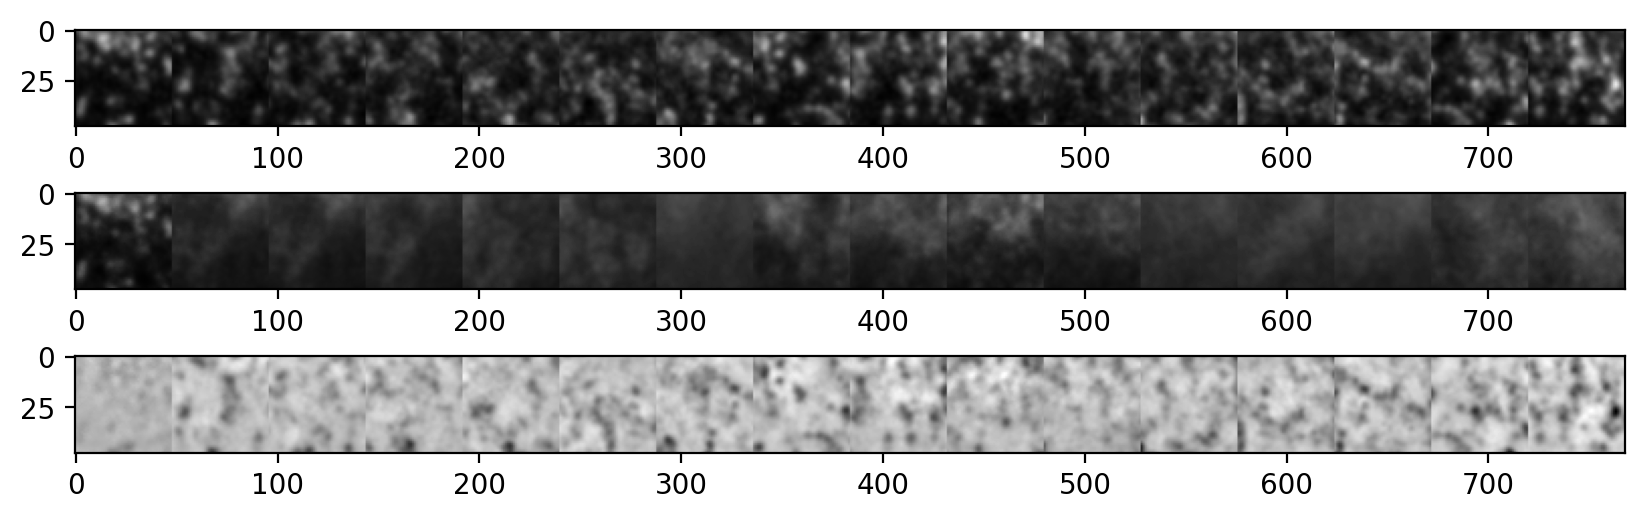

In [42]:
fig,ax=plt.subplots(3,1,figsize=(10, 3), dpi=200)
ax[0].imshow(display_image_input[4,:,:],  vmin=0, vmax=1,cmap='gray')
ax[1].imshow(display_image_output[4,:,:], vmin=0, vmax=1, cmap='gray')
ax[2].imshow(display_image_output[4,:,:]-display_image_input[4,:,:],  cmap='gray')

In [43]:

if not os.path.isdir('./checkpoints'):          
    os.mkdir('./checkpoints')

if not os.path.isdir('./checkpoints/'+model_ID):          
    os.mkdir('./checkpoints/'+model_ID)

model_ID

model.save_weights('./checkpoints/'+model_ID+'/')

(array([2.57180e+04, 1.36388e+05, 1.02446e+05, 2.59890e+04, 3.38800e+03,
        6.56000e+02, 2.26000e+02, 5.20000e+01, 3.60000e+01, 1.30000e+01]),
 array([0.00515906, 0.09394329, 0.18272751, 0.27151174, 0.36029596,
        0.44908019, 0.53786442, 0.62664864, 0.71543287, 0.80421709,
        0.89300132]),
 <BarContainer object of 10 artists>)

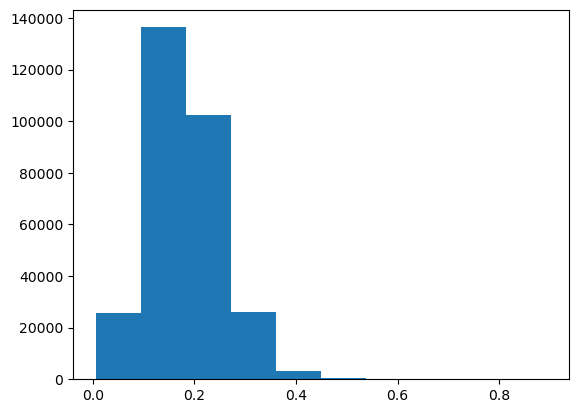

In [44]:
plt.hist(display_image_output[display_image_output>0])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f1767f7ea30>,
 'caps': [<matplotlib.lines.Line2D at 0x7f1767f7ef70>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f1767f7e790>],
 'medians': [<matplotlib.lines.Line2D at 0x7f1767f104f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f1767f10790>],
 'means': []}

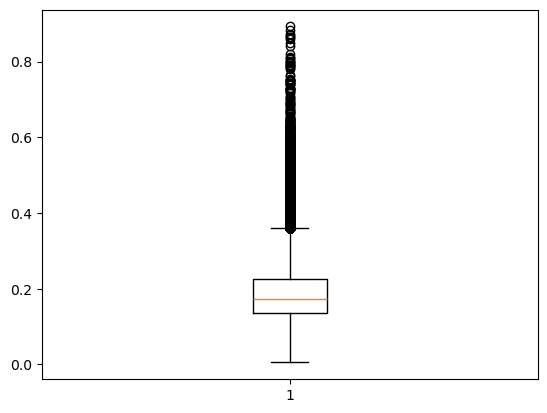

In [45]:
plt.boxplot(display_image_output[display_image_output>-100])

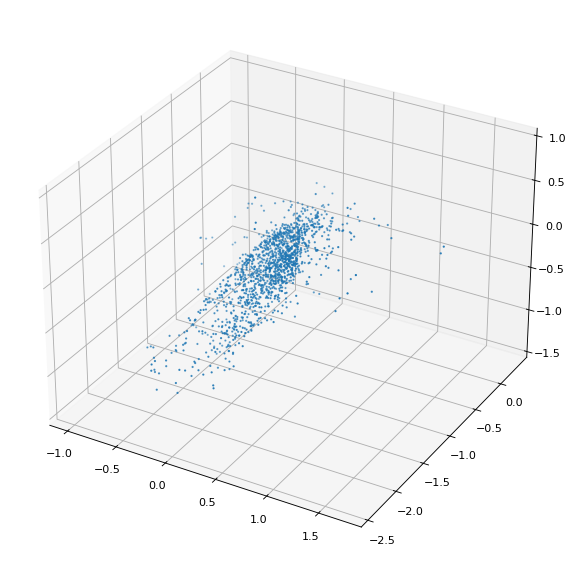

In [46]:

fig = plt.figure(figsize=(9,9), dpi=80)


if latent_dim == 2:
    ax = fig.add_subplot()
    ax.scatter(
        Z_array[:, 0],
        Z_array[:, 1])
else:
    ax = fig.add_subplot(projection='3d')
    ax.scatter(
        Z_array[:, 0],
        Z_array[:, 1],
        Z_array[:, 2],s=1)
    
fig.savefig("ACTO_xyz3D_results/"+model_ID+"_flow_distribution.png")

In [47]:
Z_array.shape

(1461, 12)

In [53]:
len_1 = Z_array.shape[0] - len_2 - len_3

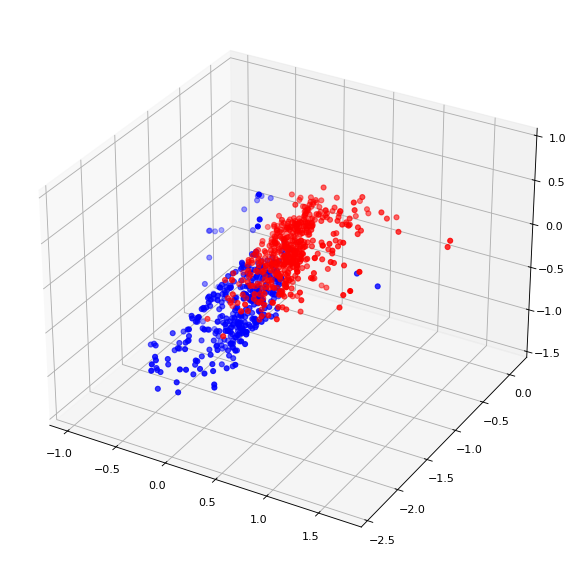

In [100]:
fig = plt.figure(figsize=(9,9), dpi=80)

nc1 = 0
nc2 = 1
nc3 = 2


if latent_dim == 2:
    ax = fig.add_subplot()
    ax.scatter(
        Z_array[0:len_1, 0],
        Z_array[0:len_1, 1],c='red')    
    ax.scatter(
        Z_array[len_1:len_1+len_2, 0],
        Z_array[len_1:len_1+len_2, 1],c='green')  
    ax.scatter(
        Z_array[len_1+len_2:, 0],
        Z_array[len_1+len_2:, 1],c='blue')  
    # ax.scatter(
    #     Z_array[672*2:672*3, 0],
    #     Z_array[672*2:672*3, 1],c='blue')    
    # ax.scatter(
    #     Z_array[672*3:672*4, 0],
    #     Z_array[672*3:672*4, 1],c='orange') 
else:
    ax = fig.add_subplot(projection='3d')
    # ax.scatter(
    #     Z_array[0:140, 0],
    #     Z_array[0:140, 1],
    #     Z_array[0:140, 2],c='red')    
    # ax.scatter(
    #     Z_array[140:280, 0],
    #     Z_array[140:280, 1],
    #     Z_array[140:280, 2],c='green')    
    # ax.scatter(
    #     Z_array[280:420, 0],
    #     Z_array[280:420, 1],
    #     Z_array[280:420, 2],c='blue')
    ax.scatter(
        Z_array[0:len_1, nc1],
        Z_array[0:len_1, nc2],
        Z_array[0:len_1, nc3],c='red')    
    # ax.scatter(
    #     Z_array[len_1:len_1+len_2, nc1],
    #     Z_array[len_1:len_1+len_2, nc2],
    #     Z_array[len_1:len_1+len_2, nc3],c='green')  
    ax.scatter(
        Z_array[len_1+len_2:, nc1],
        Z_array[len_1+len_2:, nc2],
        Z_array[len_1+len_2:, nc3],c='blue')   

# for angle in range(0, 360*4 + 1, 90):
#     # Normalize the angle to the range [-180, 180] for display
#     angle_norm = (angle + 180) % 360 - 180

#     # Cycle through a full rotation of elevation, then azimuth, roll, and all
#     elev = azim = roll = 0
#     if angle <= 360:
#         elev = angle_norm
#     elif angle <= 360*2:
#         azim = angle_norm
#     elif angle <= 360*3:
#         roll = angle_norm
#     else:
#         elev = azim = roll = angle_norm

    # Update the axis view and title
    ax.view_init(30, -60, 0)
    plt.show()
    # plt.title('Elevation: %d°, Azimuth: %d°, Roll: %d°' % (elev, azim, roll))
    # plt.savefig("ACTO_xyz3D_results/"+model_ID+"_flow_distribution_3d_rota/"+'Elev%dAzim%dRoll%d.jpg'% (elev, azim, roll))


    # fig.savefig("ACTO_xyz3D_results/"+model_ID+"_flow_distribution_0.png")




In [82]:
ax.view_init(elev, azim, roll)
plt.show()

In [80]:
model_ID

'ACTO_AE_flow_4cells_slow_ld12_ntsimple_bs512_2024092309'

In [78]:
os.mkdir("ACTO_xyz3D_results/"+model_ID+"_flow_distribution_3d_rota/")

In [ ]:
Z_array.shape

In [ ]:
fig = plt.figure(figsize=(9,9), dpi=80)



ax = fig.add_subplot()
ax.scatter(
    Z_array[0:672, 0],
    Z_array[0:672, 1],c='red')    
ax.scatter(
    Z_array[672:, 0],
    Z_array[672:, 1],c='green')  

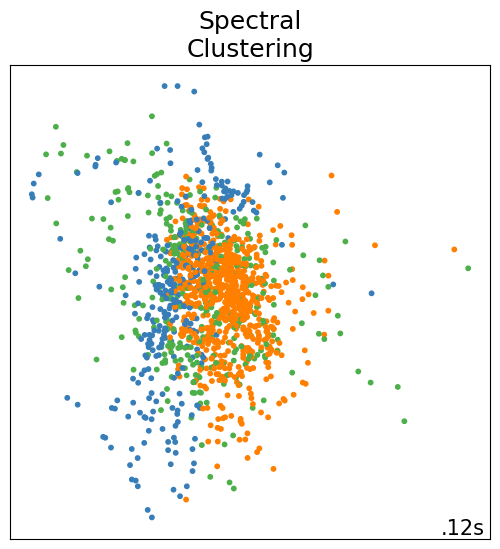

In [58]:
# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 500
seed = 30
rng = np.random.RandomState(seed)
# Anisotropicly distributed data
random_state = 170
no_structure = rng.rand(n_samples, 2), None
# ============
# Set up cluster parameters
# ============
fig_clustering = plt.figure(figsize=(5, 5))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 3,
    "n_clusters": 3,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
    "allow_single_cluster": True,
    "hdbscan_min_cluster_size": 15,
    "hdbscan_min_samples": 3,
    "random_state": 42,
}

datasets = [
    (no_structure, {}),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    
    params = default_base.copy()
    params.update(algo_params)
   
    X = Z_array
    y = np.zeros(X.shape[0])

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(
        n_clusters=params["n_clusters"],
        random_state=params["random_state"],
    )
    spectral = cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        eigen_solver="arpack",
        affinity="nearest_neighbors",
        random_state=params["random_state"],
    )
    
    clustering_algorithms = (
        # ("MeanShift", ms),
        ("Spectral\nClustering", spectral),
        # ("MiniBatch\nKMeans", two_means),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)


        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()

fig_clustering.savefig("results/"+model_ID+"_flow_clustering.png")

In [ ]:
dec_dir = '/mnt/d/lding/actomyosin/ACTO_decoded_results/'

if not os.path.isdir(dec_dir):          
    os.mkdir(dec_dir)

now=datetime.now()
current_time = now.isoformat()[5:19]
print(current_time)


model_dec_dir = dec_dir+'decoded_results_'+ model_ID+'_' + current_time
model_org_dir = dec_dir+'orgin_imgs_'+ model_ID+'_' + current_time
analysis_dir = dec_dir+'analysis_results_'+ model_ID+'_' + current_time


if not os.path.isdir(model_dec_dir):          
    os.mkdir(model_dec_dir)

if not os.path.isdir(model_org_dir):          
    os.mkdir(model_org_dir)

if not os.path.isdir(analysis_dir):          
    os.mkdir(analysis_dir)



csv_output = pd.DataFrame(columns=['title', 'labelnumber','cluster_ID'])
for x_input, y_input in train_dataset:
    z = model.encode(x_input)
    x_output = model.decode(z).numpy().reshape([len(y_input),8, 48, 48])
    
    # y_pred = algorithm.predict(z.numpy())
    for i in range(z.numpy().shape[0]):
        input_label = y_input[i].numpy()
        input_img = x_input[i,:,:,:,0].numpy().squeeze()
        output_img = x_output[i,:,:,:]
        label_str = str(int(input_label)).zfill(12)
        ind = np.where(Label_array == input_label)        
        pred_ID = y_pred[ind[0][0]]        
        
        # title = 'decoded'+label_str+'.tif'
        
        # tifffile.imwrite(os.path.join(model_dec_dir,'dec_'+title), output_img)
       
        # title = 'orgin'+label_str+'.tif'
        
        # tifffile.imwrite(os.path.join(model_org_dir,'org_'+title), input_img)
        
        s = pd.DataFrame([[title, input_label,pred_ID]], columns=['title', 'labelnumber','cluster_ID'])
        csv_output = pd.concat([csv_output, s], ignore_index=True, axis=0)
        


csv_output.to_csv(os.path.join(analysis_dir,model_ID+'_clustering.csv'))
                           
        
       

In [ ]:
nxy = 10
# output_manifold = np.zeros(8,nxy*48,nxy*48)


if latent_dim == 2:
    z0_max = np.percentile(Z_array[:,0], 99)
    z0_min = np.percentile(Z_array[:,0], 1)
    z1_max = np.percentile(Z_array[:,1], 99)
    z1_min = np.percentile(Z_array[:,1], 1)


    
    x = np.linspace(z0_min, z0_max,nxy)
    y = np.linspace(z1_min, z1_max,nxy)
    xv, yv = np.meshgrid(x, y)

    # plt.scatter(xv,yv)

    zv = np.concatenate((xv.reshape([nxy*nxy,1]),yv.reshape([nxy*nxy,1])), axis=1)

    x_output_manifold = model.decode(zv).numpy().reshape([nxy,nxy, 8,48,48])


    for t in range(0,8):
        fig_manifold, axarr = plt.subplots(nxy, nxy, figsize=(nxy, nxy))

        for i in range(nxy):
            for j in range(nxy):    
                axarr[i, j].axis('off')
                axarr[i, j].imshow(x_output_manifold[i,j,t,:,:],cmap=plt.cm.gray)
            
        
        fig_manifold.savefig("results/"+model_ID+"_manifold_"+str(t)+".png") 